In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Problem 1: Geometric Brownian Motion

$$ dS_t = \mu S_tdt + \sigma S_t dW_t,  \\ S_0 = s_0$$

$$ S_t = S_0 \exp [(\mu - \sigma^2 /2)t + \sigma W_t] $$

In [3]:
n = 3650
mu = 0.06
sigma = 0.2
M = 10.0
s0 = 100.0

def exact_simulation(s0, mu, sigma, n):
    dt = 1.0/365.0 # frequency = delta = T/n where T = 1 year and n = 365 days
    dz = np.random.randn(n)*np.sqrt(dt)
    S = s0 * np.exp(np.cumsum((mu-(sigma**2)/2)*dt + sigma*dz))
    return S

In [ ]:
# Alternative way from Francesco 
def gen_paths(S0, mu, sigma):
    dt=1.0/365.0
    paths = np.zeros(len(index))
    paths[0] = S0
    for t in range(1, len(index)):
        rand = np.random.standard_normal(1)
        paths[t] = paths[t - 1] * np.exp((mu- 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths, dt

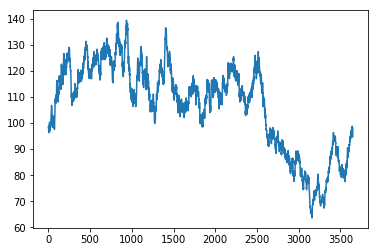

In [4]:
plt.plot(exact_simulation(s0, mu, sigma, n))
plt.show()

In [5]:
# daily continuously compounded returns: r_t = log(1 + R_t) 
prices = exact_simulation(s0, mu, sigma, n)
prices_lagged = np.diff(prices)
R_t = prices_lagged/prices[:-1]
r_t = np.log(1 + R_t)

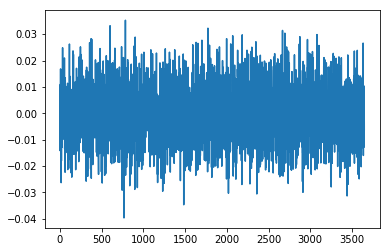

In [6]:
plt.plot(r_t)

In [7]:
def compute_annual_mean_std(log_ret, n, dt):
    annual_mean = np.mean(log_ret)/dt
    annual_std = np.std(log_ret)/np.sqrt(dt)
    return annual_mean, annual_std

In [8]:
dt = 1.0/365.0
annualised_mean, annualised_std = compute_annual_mean_std(r_t, n, dt)
print(f"Annualised mean of daily returns: {annualised_mean} \n")
print(f"Annualised std of daily returns: {annualised_std}")

Annualised mean of daily returns: 0.010621444500155855 

Annualised std of daily returns: 0.1983179998588671


### Problem 2

There are 25202 observations


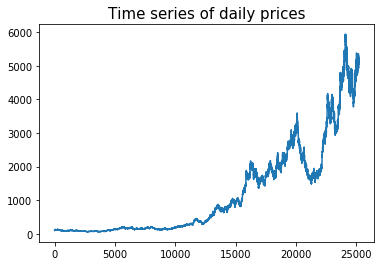

In [58]:
index = pd.period_range(start="01-01-1950", end="31-12-2018", freq="D")
simulated_ts = pd.DataFrame(exact_simulation(s0, mu, sigma, len(index)), index, columns=["price"])
plt.figure()
plt.plot(list(simulated_ts.price))
plt.title("Time series of daily prices", size=15)
print(f"There are {len(simulated_ts)} observations")

Text(0.5,1,'Time series of average monthly prices')

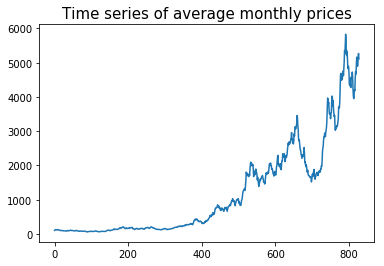

In [60]:
plt.figure()
plt.plot(list(simulated_ts.price.resample("M").mean()))
plt.title("Time series of average monthly prices", size=15)

### Problem 3: Simulated Dataset

In [36]:
#function which define log returns: 
def compute_log_ret(series):
    normal_ret = np.diff(series)/series[:-1] 
    return np.log(1 + normal_ret)

Summary for daily returns :

count    25201.000000
mean         0.000129
std          0.010458
min         -0.046884
25%         -0.006946
50%          0.000169
75%          0.007128
max          0.045584
Name: price, dtype: float64
Annualised mean, std : (3.539092522784976e-07, 0.0005474083178651631)

Summary for weekly returns :

count    3601.000000
mean        0.000904
std         0.027635
min        -0.097489
25%        -0.017519
50%         0.001293
75%         0.020505
max         0.086920
Name: price, dtype: float64
Annualised mean, std : (1.738505585699858e-05, 0.0038317901366218756)

Summary for monthly returns :

count    827.000000
mean       0.003748
std        0.058819
min       -0.161113
25%       -0.037360
50%        0.003941
75%        0.040697
max        0.235148
Name: price, dtype: float64
Annualised mean, std : (0.0003123134926901031, 0.01696931825594048)



<Figure size 432x288 with 0 Axes>

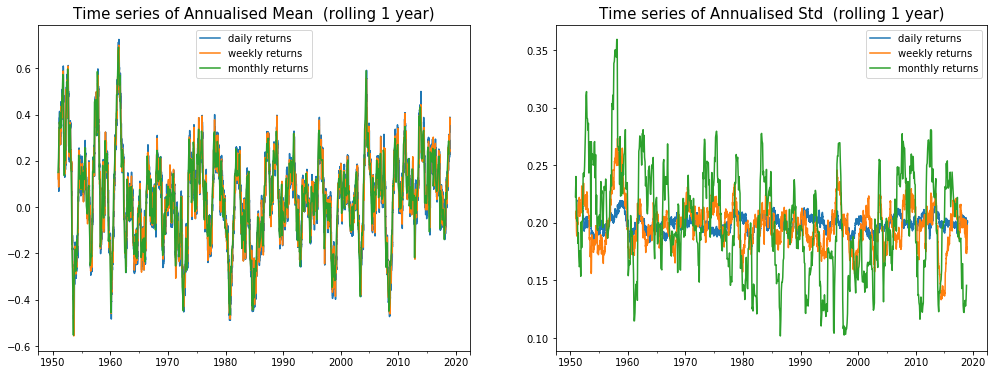

In [49]:
#a)
log_daily_ret = compute_log_ret(simulated_ts.price)
log_weekly_ret = compute_log_ret(simulated_ts.price.resample("W").first()) # log of weekly returns
log_monthly_ret = compute_log_ret(simulated_ts.price.resample("M").first()) # log of montly returns

log_ts = {"daily returns": (log_daily_ret, 365), 
         "weekly returns": (log_weekly_ret, 52), 
         "monthly returns": (log_monthly_ret, 12)}

plt.figure()
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,6))

def summarise_ts(freq_dict: dict, extra_tit=""): # function takes a dict {name of series: (series, dt)}

    for tit,freq in freq_dict.items():

        n = len(freq)
        #b)
        print(f"Summary for {tit} {extra_tit}:\n")
        print(freq[0].describe())
        #c)
        annual_mean, annual_std = compute_annual_mean_std(freq[0], len(freq[0]), freq[1])
        print(f"Annualised mean, annualised std {extra_tit}: {annual_mean, annual_std}\n")

        # d) annualised means and stds of rolling-ed log returns
        rolling_log_ret_mean = freq[0].rolling(freq[1]).mean()*freq[1]
        rolling_log_ret_std = freq[0].rolling(freq[1]).std()*np.sqrt(freq[1])

        rolling_log_ret_mean.plot(label=tit, ax=ax1)
        ax1.set_title(f"Time series of Annualised Mean {extra_tit} (rolling 1 year)", size=15)
        ax1.legend(loc="best")

        rolling_log_ret_std.plot(label=tit, ax=ax2)
        ax2.set_title(f"Time series of Annualised Std {extra_tit} (rolling 1 year)", size=15)
        ax2.legend(loc="best")
        
summarise_ts(log_ts)
plt.show()

In [55]:
D_avg = simulated_ts #conforming in variables names

#)f
theretical_mu=0.06
theretical_var=0.04 #here we are working over groups of lenght 1 year so T=1
logret = np.log(D_avg/D_avg.shift(1))
Annual_bins= logret.resample('A')
Annual_bins = Annual_bins.mean()*365
day_est_mean = Annual_bins.mean()
dailysqrt = logret **2
t_var_sigma_d=2*theretical_var**2/365+4*theretical_mu**2*theretical_var/365**2
t_mu_sigma_d= theretical_var+dailysqrt.mean()
d_var = dailysqrt.resample('A')
var_d= d_var.mean()*365

#monthly
M_avg = D_avg.resample('M',convention = 'start').first()
m_logret = np.log(M_avg/M_avg.shift(1))
mAnnual_bins= m_logret.resample('A')
mAnnual_bins = mAnnual_bins.mean()*12
month_est_mean = mAnnual_bins.mean()
monthsqrt = m_logret **2
t_var_sigma_m=2*theretical_var**2/12+4*theretical_mu**2*theretical_var/12**2
t_mu_sigma_m= theretical_var+monthsqrt.mean()
m_var = monthsqrt.resample('A')
var_m= m_var.mean()*12

print("Theoretical Moments of daily Sample Mean       : mean : 0.0600   variance: 0.0400")
print("Estimated  Moments of daily Sample Mean        : mean : %1.5f   variance: %1.5f"%( day_est_mean,Annual_bins.var()))
print("Theoretical Moments of  daily Sample variance  : mean : %1.5f   variance: %1.10f"%( t_mu_sigma_d,t_var_sigma_d))
print("estimated Moments of  daily Sample variance    : mean : %1.5f   variance: %1.10f"%( var_d.mean(),var_d.var()))

print("Theoretical Moments of monthly Sample Mean         : mean : 0.0600    variance: 0.0400")
print("Estimated  Moments of monthly Sample Mean          : mean : %1.5f   variance: %1.5f"%( month_est_mean,mAnnual_bins.var()))

print("Theoretical Moments of  monthly Sample variance    : mean : %1.5f   variance: %1.10f"%( t_mu_sigma_m,t_var_sigma_m))
print("estimated Moments of  monthly Sample variance      : mean : %1.5f   variance: %1.10f"%( var_m.mean(),var_m.var()))

Theoretical Moments of daily Sample Mean       : mean : 0.0600   variance: 0.0400
Estimated  Moments of daily Sample Mean        : mean : 0.04718   variance: 0.02941
Theoretical Moments of  daily Sample variance  : mean : 0.04011   variance: 0.0000087714
estimated Moments of  daily Sample variance    : mean : 0.03993   variance: 0.0000067617
Theoretical Moments of monthly Sample Mean         : mean : 0.0600    variance: 0.0400
Estimated  Moments of monthly Sample Mean          : mean : 0.04500   variance: 0.03760
Theoretical Moments of  monthly Sample variance    : mean : 0.04347   variance: 0.0002706667
estimated Moments of  monthly Sample variance      : mean : 0.04164   variance: 0.0004096350


### Problem 4: WRDS dataset

In [ ]:
import wrds
# db = wrds.Connection(wrds_username='hienle')
# db.create_pgpass_file()

In [113]:
# Download daily stock returns 2 for the period starting on January 1 st , 2000 and ending
# on December 12 st , 2018 of the following companies: Apple, Goldman Sachs, Microsoft,
# Procter and Gamble, and General Electric.

companies = {"aapl": 7, "gs": 35048, "msft": 8048, "pg": 21446, "ge": 20792}
ind = pd.date_range(start="01-01-2001", end="31-12-2018", freq="D")
df = pd.DataFrame(index=ind)

In [114]:
df.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=6574, freq='D')

In [115]:
# IMPORTANT NOTE: the data obtained contains DAILY RETURNS, not daily closing prices.

# for key,value in companies.items():
#     rets = db.raw_sql(f"select date, ret from crsp.dsf where permco in ({value}) \
#                       and date>='2001-01-01' and date<='2018-12-31'").set_index("date").rename(columns={"ret":key})
    
#     df = pd.merge(df, rets, left_index=True, right_index=True)
    
# df.to_csv("as1_ex4_data.csv")

In [18]:
wrds_df = pd.read_csv("as1_ex4_data.csv", index_col=0)
wrds_df.index = pd.to_datetime(wrds_df.index)

In [53]:
wrds_df.resample("M").last()

,aapl,gs,msft,pg,ge
2001-01-31,-0.005747,-0.041055,-0.036489,0.010408,-0.005838
2001-02-28,-0.058065,-0.067012,-0.006316,-0.002829,-0.031250
2001-03-31,-0.020417,-0.034052,-0.012415,0.022041,0.011111
2001-04-30,-0.027099,-0.019798,0.009386,0.003677,-0.028428
2001-05-31,0.008595,0.003588,-0.000145,-0.002020,-0.000408
2001-06-30,-0.012319,-0.009238,0.003574,0.002357,-0.002455
2001-07-31,-0.007396,0.005684,0.005927,-0.001125,-0.002294
2001-08-31,0.040381,0.006155,0.001932,-0.005899,0.019403
2001-09-30,0.000000,0.035559,0.024219,0.005387,0.034771
2001-10-31,-0.002273,-0.023610,-0.012398,-0.005660,0.001926


Summary for daily returns of AAPL:

count    4527.000000
mean        0.001132
std         0.023080
min        -0.197470
25%        -0.010026
50%         0.000860
75%         0.012450
max         0.130194
Name: aapl, dtype: float64
Annualised mean, std of AAPL: (3.101403854035045e-06, 0.001207943714209071)

Summary for weekly returns of AAPL:

count    940.000000
mean       0.005518
std        0.049161
min       -0.290710
25%       -0.022411
50%        0.008078
75%        0.034924
max        0.220095
Name: aapl, dtype: float64
Annualised mean, std of AAPL: (0.00010611593957556288, 0.00681380579436661)

Summary for monthly returns of AAPL:

count    216.000000
mean       0.023517
std        0.105660
min       -0.453292
25%       -0.027271
50%        0.030809
75%        0.089654
max        0.337724
Name: aapl, dtype: float64
Annualised mean, std of AAPL: (0.001959779723688889, 0.030430629873056364)



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

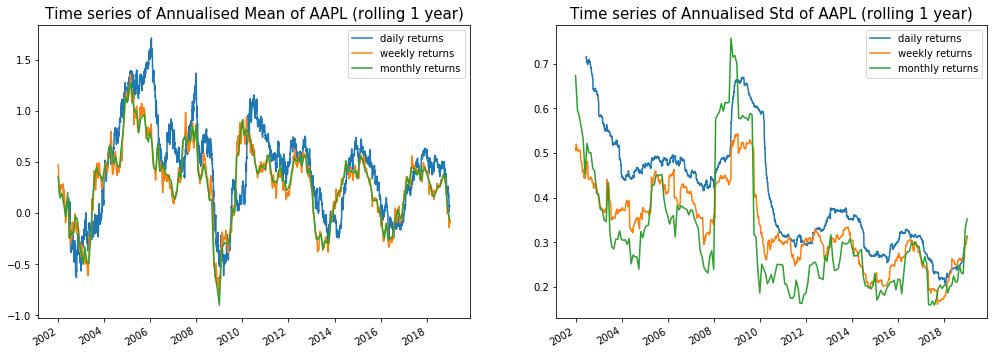

Summary for daily returns of GS:

count    4527.000000
mean        0.000141
std         0.022295
min        -0.210223
25%        -0.009903
50%         0.000244
75%         0.010450
max         0.234818
Name: gs, dtype: float64
Annualised mean, std of GS: (3.876032809764343e-07, 0.0011668545883281181)

Summary for weekly returns of GS:

count    940.000000
mean       0.000766
std        0.047307
min       -0.427937
25%       -0.022032
50%        0.003461
75%        0.025272
max        0.356032
Name: gs, dtype: float64
Annualised mean, std of GS: (1.4726982640992958e-05, 0.00655676988569282)

Summary for monthly returns of GS:

count    216.000000
mean       0.004757
std        0.083148
min       -0.290885
25%       -0.050073
50%        0.014704
75%        0.056586
max        0.195242
Name: gs, dtype: float64
Annualised mean, std of GS: (0.0003963949873094094, 0.023947247350318744)



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

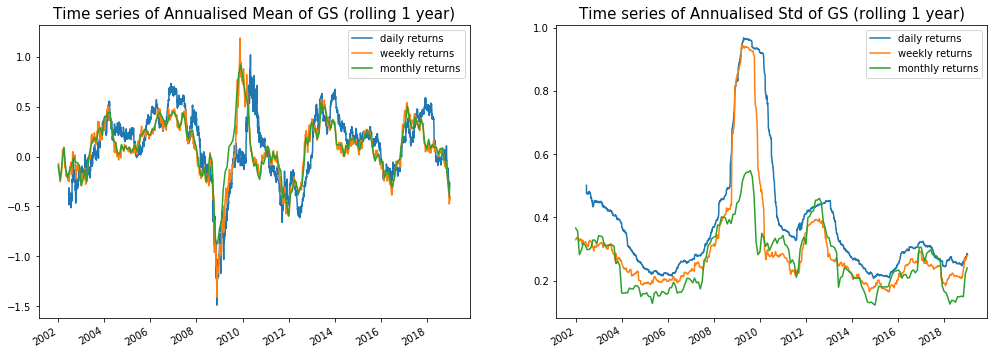

Summary for daily returns of MSFT:

count    4527.000000
mean        0.000435
std         0.017863
min        -0.124578
25%        -0.007842
50%         0.000271
75%         0.008638
max         0.170626
Name: msft, dtype: float64
Annualised mean, std of MSFT: (1.1911081964408925e-06, 0.0009348768663312223)

Summary for weekly returns of MSFT:

count    940.000000
mean       0.002210
std        0.036112
min       -0.219669
25%       -0.016186
50%        0.002047
75%        0.021435
max        0.143311
Name: msft, dtype: float64
Annualised mean, std of MSFT: (4.250740151743964e-05, 0.005005195696244183)

Summary for monthly returns of MSFT:

count    216.000000
mean       0.009887
std        0.070669
min       -0.189425
25%       -0.035620
50%        0.018235
75%        0.051449
max        0.306621
Name: msft, dtype: float64
Annualised mean, std of MSFT: (0.0008239556885919331, 0.020353063443489878)



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

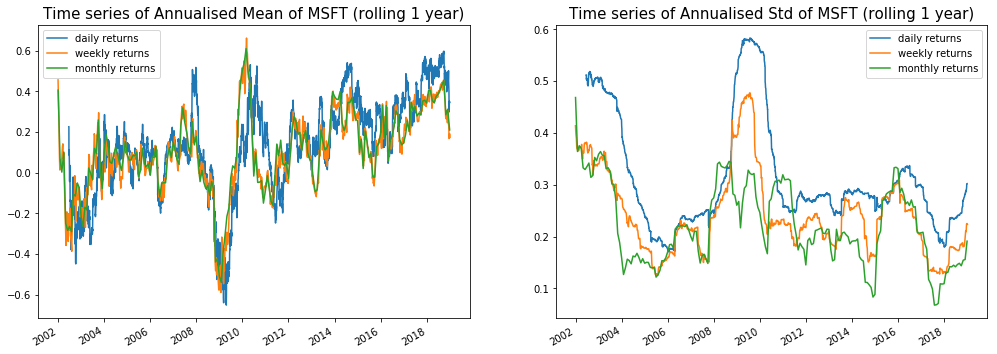

Summary for daily returns of PG:

count    4527.000000
mean        0.000297
std         0.011272
min        -0.083161
25%        -0.004988
50%         0.000300
75%         0.005703
max         0.097257
Name: pg, dtype: float64
Annualised mean, std of PG: (8.125534486310161e-07, 0.0005899594487537618)

Summary for weekly returns of PG:

count    940.000000
mean       0.001451
std        0.023812
min       -0.187835
25%       -0.010057
50%        0.002197
75%        0.014371
max        0.118140
Name: pg, dtype: float64
Annualised mean, std of PG: (2.7904196919716186e-05, 0.003300428749251565)

Summary for monthly returns of PG:

count    216.000000
mean       0.006634
std        0.042314
min       -0.128388
25%       -0.018551
50%        0.009741
75%        0.032006
max        0.108149
Name: pg, dtype: float64
Annualised mean, std of PG: (0.0005528115766126444, 0.012186629468046042)



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

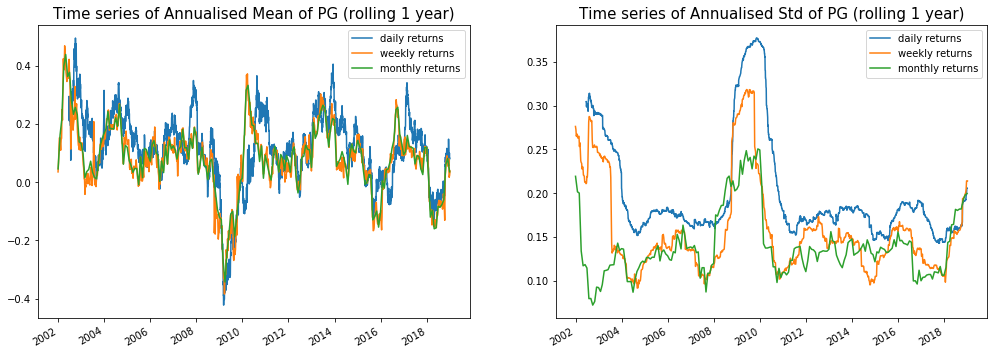

Summary for daily returns of GE:

count    4527.000000
mean       -0.000282
std         0.019175
min        -0.136841
25%        -0.008103
50%         0.000000
75%         0.007908
max         0.179844
Name: ge, dtype: float64
Annualised mean, std of GE: (-7.73286689580261e-07, 0.0010035392869553149)

Summary for weekly returns of GE:

count    940.000000
mean      -0.001314
std        0.041075
min       -0.246562
25%       -0.018518
50%       -0.000495
75%        0.018517
max        0.289828
Name: ge, dtype: float64
Annualised mean, std of GE: (-2.527592996860395e-05, 0.005693072836683884)

Summary for monthly returns of GE:

count    216.000000
mean      -0.005171
std        0.079993
min       -0.356068
25%       -0.044020
50%       -0.003015
75%        0.040110
max        0.214621
Name: ge, dtype: float64
Annualised mean, std of GE: (-0.00043088117774948926, 0.02303838313999434)



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

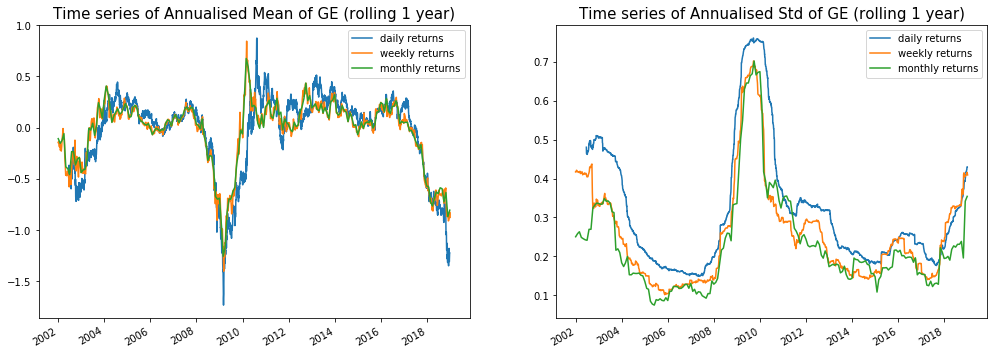

In [61]:
for company in wrds_df.columns:
    plt.figure()
    rets = wrds_df[company]
    log_daily_ret = np.log(1 + rets) 
    log_weekly_ret = np.log(1 + rets.resample("W").sum()) # compounding returns to get a number at low frequency
    log_monthly_ret = np.log(1 + rets.resample("M").sum()) 
 
    ts = {"daily returns": (log_daily_ret, 365), 
         "weekly returns": (log_weekly_ret, 52), 
         "monthly returns": (log_monthly_ret, 12)}
    plt.figure()
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,6))
    summarise_ts(ts, extra_tit=f"of {company.upper()}")
    plt.show()